# PBC Classification: 
# Classification using Convolutional Neural Networks in Pytorch

#### Michele Waters

### Loading the Data

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow

In [2]:
#Load data
data = np.load("./training_data.npy", allow_pickle=True)

In [3]:
first_saved_obs = data[0][0]

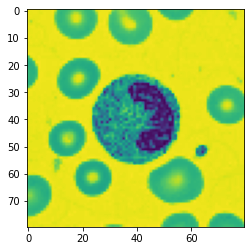

In [4]:
imshow(first_saved_obs)

In [5]:
file_names=['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
class_dict={file_names[i]:i for i in range(len(file_names))}
class_dict

{'basophil': 0,
 'eosinophil': 1,
 'erythroblast': 2,
 'ig': 3,
 'lymphocyte': 4,
 'monocyte': 5,
 'neutrophil': 6,
 'platelet': 7}

In [6]:
#Target values
targets=data[:,1]
pd.Series(targets).value_counts().sort_index()

0    1218
1    3117
2    1551
3    2895
4    1214
5    1420
6    3329
7    2348
dtype: int64

### Splitting the Data and Building the CNN Model

In [7]:
#Set device as 'cuda', to speed up training time & perform calculations on GPU
import torch
torch.device("cuda")

device(type='cuda')

In [8]:
torch.tensor(data[:,0][0])

tensor([[231, 232, 232,  ..., 233, 229, 231],
        [233, 231, 232,  ..., 228, 229, 231],
        [232, 232, 231,  ..., 231, 230, 230],
        ...,
        [231, 233, 232,  ..., 169, 183, 231],
        [233, 231, 231,  ..., 165, 168, 196],
        [230, 233, 230,  ..., 168, 168, 173]], dtype=torch.uint8)

In [9]:
#Convert data and targets to tensors
X=torch.tensor(list(data[:,0]))
y=torch.tensor(list(targets))

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_validate, y_train, y_validate=train_test_split(X, y, stratify=y, shuffle=True, random_state=42, test_size=0.23)

In [12]:
X_train.shape, X_validate.shape

(torch.Size([13160, 80, 80]), torch.Size([3932, 80, 80]))

In [13]:
13160*80*80

84224000

In [41]:
#batch size of 70
13160/70

188.0

In [42]:
X_train_reshaped = X_train.reshape(-1, 70, 1, 80, 80)
y_train_reshaped = y_train.reshape(-1, 70)

In [43]:
X_train_reshaped.shape, y_train_reshaped.shape

(torch.Size([188, 70, 1, 80, 80]), torch.Size([188, 70]))

In [44]:
#Combined/zipped training data
X_y_train = list(zip(X_train_reshaped, y_train_reshaped))

In [45]:
import torch.nn as nn
import torch.nn.functional as F

In [46]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2=nn.Conv2d(6, 12, kernel_size=3, stride=1, padding=1)
      
    def forward(self, X):
        A1=F.relu(self.conv1(X))
        P1=F.avg_pool2d(A1, kernel_size=2)
        A2=F.relu(self.conv2(P1))
        P2=F.avg_pool2d(A2, kernel_size=2)
        return P2

In [47]:
net_with_forward = Net()

In [48]:
first_batch = X_train_reshaped[0].float()

In [49]:
outputs_second_pooling = net_with_forward(first_batch)

outputs_second_pooling.shape


torch.Size([70, 12, 20, 20])

In [50]:
outputs_second_pooling.reshape(-1, 12*20*20)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 6.8684],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 9.3780],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 9.3553],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 7.5162],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 6.7223],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 9.0455]],
       grad_fn=<ViewBackward>)

* Now have an output for each observation of 12 kernels each of size 20 by 20.
* $output = \frac{i - k + 2p}{s} + 1$ 
* where k=kernel_size, s=stride, p=padding
* Double check the output by calculating the output dimension from first convolutional sequence (that ends with avgpooling):

In [51]:
#First CNN output
((80-5+2*2)/2)+1

# Round down 40.5 -> 40

40.5

In [52]:
#Second CNN output
((40-3+2*1)/2)+1

# 20.5 -> 20

20.5

We correctly predict an output of 20x20 for the 2nd CNN output. Let's add to our neural network:

In [53]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2=nn.Conv2d(6, 12, kernel_size=3, stride=1, padding=1)
        self.L1=nn.Linear(12*20*20, 64) #64 neurons
        self.L2=nn.Linear(64, 8) #final output of 8 classes/cell types
      
    def forward(self, X):
        A1=F.relu(self.conv1(X))
        P1=F.avg_pool2d(A1, kernel_size=2)
        A2=F.relu(self.conv2(P1))
        P2=F.avg_pool2d(A2, kernel_size=2)
        A3=F.relu(self.L1(P2.reshape(-1, 12*20*20)))
        A4=F.log_softmax(self.L2(A3), dim=1)
        return A4


In [54]:
net_with_linear = Net()

In [55]:
first_batch.shape

torch.Size([70, 1, 80, 80])

In [56]:
net_with_linear(first_batch).shape

torch.Size([70, 8])

We now have 8 outputs for each of the 280 observations in the batch.

### Training the CNN Model

Let's use a learning rate of 0.0005 and 15 epochs to perform training

In [57]:
#Import the adam optimizer
import torch.optim as optim
optimizer = optim.Adam(net_with_linear.parameters(), lr=.0005)

In [58]:
#Import Cross entropy loss
x_loss=nn.CrossEntropyLoss()

In [59]:
for epoch in range(15):
    for X_batch, y_batch in X_y_train:
        net_with_linear.zero_grad()
        predictions=net_with_linear(X_batch.float())
        loss=x_loss(predictions, y_batch)
        loss.backward()
        optimizer.step()
    print("Epoch: ", epoch, "; Loss: ", round(float(loss), 4))

Epoch:  0 ; Loss:  1.3554
Epoch:  1 ; Loss:  1.0562
Epoch:  2 ; Loss:  0.9745
Epoch:  3 ; Loss:  0.8699
Epoch:  4 ; Loss:  0.7617
Epoch:  5 ; Loss:  0.6291
Epoch:  6 ; Loss:  0.5346
Epoch:  7 ; Loss:  0.484
Epoch:  8 ; Loss:  0.4597
Epoch:  9 ; Loss:  0.4444
Epoch:  10 ; Loss:  0.4053
Epoch:  11 ; Loss:  0.3953
Epoch:  12 ; Loss:  0.3759
Epoch:  13 ; Loss:  0.407
Epoch:  14 ; Loss:  0.3351


### Testing Validation Set

In [60]:
X_validate_reshaped= X_validate.reshape(-1, 1, 80, 80)

In [61]:
X_validate_reshaped.shape

torch.Size([3932, 1, 80, 80])

In [62]:
predictions= net_with_linear(X_validate_reshaped.float())

Calculate argmax to get classification:

In [63]:
class_predictions = torch.argmax(predictions, axis=1)
class_predictions=class_predictions.detach().numpy()


In [64]:
class_predictions

array([1, 6, 3, ..., 6, 6, 6])

Calculate model accuracy:

In [65]:
from sklearn.metrics import accuracy_score

In [66]:
accuracy_score(list(class_predictions), list(y_validate))

0.758646998982706

### Notes

* A convolutional neural network was constructed by initializing two convolutional layers and two linear layers, with the layers having the following architecture:



1. Conv --> Relu --> AvgPool
2. Conv --> Relu --> AvgPool
3. L1 --> Relu
4. L2 --> log_softmax


* Future iterations may involve exploring more extensive pre-processing steps (i.e. masking and filtration options in Python or ImageJ) to remove RBCs present in each image. However, the ultimate goal of this personal project is to gain more experience using neural networks with Pytorch and Tensorflow.